# Example optimisation with stochastic nonlocal modifications and gradient descent

## Imports

In [1]:
import seaborn as sns

In [2]:
from ship_routing.core import Route, WayPoint
from ship_routing.data import (
    load_currents,
    load_winds,
    load_waves,
)
from ship_routing.convenience import (create_route, stochastic_search, gradient_descent)
from ship_routing.algorithms import (
    crossover_routes_minimal_cost,
    crossover_routes_random,
)

<frozen abc>:106: FutureWarning: xarray subclass HashableDataset should explicitly define __slots__


In [3]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from copy import deepcopy
import tqdm
from random import choice
import xarray as xr
import shapely

## Parameters

In [4]:
population_size = 240

# reproducibility
random_seed = 345

# data sources
current_data_store = "/Users/wrath/src/git.geomar.de/willi-rath/ship_routing_data/data/cmems_mod_glo_phy_my_0.083deg_P1D-m_time_2021_lat_+10_+65_lon_-100_+010_uo-vo.zarr/"
wave_data_store = "/Users/wrath/src/git.geomar.de/willi-rath/ship_routing_data/data/cmems_mod_glo_wav_my_0.2deg_PT3H-i_time_2021_lat_+10_+65_lon_-100_+010_VHM0-VMDR.zarr/"
wind_data_store = "/Users/wrath/src/git.geomar.de/willi-rath/ship_routing_data/data/cmems_obs-wind_glo_phy_my_l4_0.125deg_PT1H_time_2021_lat_+10_+65_lon_-100_+010_eastward_wind-northward_wind.zarr/"

# initial route
lon_waypoints = [-80.5, -10.0]
lat_waypoints = [30.0, 50.0]
time_start = "2021-08-13T12:00"
time_end = "2021-08-21T12:00"
speed_knots = None  # either one time and speed or both times needed
time_resolution_hours = 6.0

# stochastic search parameters
stoch_number_of_iterations = 5
stoch_acceptance_rate_target = 0.01

# gradient descent parameters
grad_num_iterations = 10
grad_learning_rate_percent_time = 0.5
grad_time_increment = 1_200
grad_learning_rate_percent_along = 0.5
grad_dist_shift_along = 15_000
grad_learning_rate_percent_across = 0.5
grad_dist_shift_across = 15_000

# experiment id
experiment_id = 2

In [5]:
np.random.seed(random_seed)

## Define a route

In [6]:
route_0 = create_route(
    lon_waypoints=lon_waypoints,
    lat_waypoints=lat_waypoints,
    time_start=np.datetime64(time_start),
    speed_knots=16.0,
    time_resolution_hours=time_resolution_hours,
)

route_0

Route(way_points=(WayPoint(lon=np.float64(-80.5), lat=np.float64(30.0), time=np.datetime64('2021-08-13T12:00:00')), WayPoint(lon=-79.139109120998, lat=31.0660194892236, time=np.datetime64('2021-08-13T17:56:38.057')), WayPoint(lon=-77.74773455145981, lat=32.11718478868122, time=np.datetime64('2021-08-13T23:53:16.114')), WayPoint(lon=-76.32434269596945, lat=33.15253762198593, time=np.datetime64('2021-08-14T05:49:54.171')), WayPoint(lon=-74.86738735157664, lat=34.17107009771546, time=np.datetime64('2021-08-14T11:46:32.228')), WayPoint(lon=-73.37531802844259, lat=35.171722599509195, time=np.datetime64('2021-08-14T17:43:10.285')), WayPoint(lon=-71.84659012535298, lat=36.15338189535891, time=np.datetime64('2021-08-14T23:39:48.342')), WayPoint(lon=-70.27967718012803, lat=37.11487954484631, time=np.datetime64('2021-08-15T05:36:26.399')), WayPoint(lon=-68.67308541317253, lat=38.054990696475144, time=np.datetime64('2021-08-15T11:33:04.457')), WayPoint(lon=-67.02537077033455, lat=38.9724333813612

In [7]:
print("speed (m/s)", np.mean([l.speed_ms for l in route_0.legs]))

speed (m/s) 8.23111900896213


## Load and plot currents, winds, waves

In [8]:
currents = load_currents(
    data_file=current_data_store,
    engine="zarr",
    chunks="auto",
)
currents["speed"] = ((currents.to_array() ** 2).sum("variable") ** 0.5).where(
    ~currents.uo.isnull()
)

currents

<xarray.HashableDataset> Size: 4GB
Dimensions:  (lat: 661, lon: 1321, time: 365)
Coordinates:
    depth    float32 4B ...
  * lat      (lat) float32 3kB 10.0 10.08 10.17 10.25 ... 64.75 64.83 64.92 65.0
  * lon      (lon) float32 5kB -100.0 -99.92 -99.83 -99.75 ... 9.833 9.917 10.0
  * time     (time) datetime64[ns] 3kB 2021-01-01 2021-01-02 ... 2021-12-31
Data variables:
    uo       (time, lat, lon) float32 1GB dask.array<chunksize=(38, 661, 1321), meta=np.ndarray>
    vo       (time, lat, lon) float32 1GB dask.array<chunksize=(38, 661, 1321), meta=np.ndarray>
    speed    (time, lat, lon) float32 1GB dask.array<chunksize=(38, 661, 1321), meta=np.ndarray>

In [9]:
winds = load_winds(
    data_file=wind_data_store,
    engine="zarr",
    chunks="auto",
)
winds["speed"] = ((winds.to_array() ** 2).sum("variable") ** 0.5).where(
    ~winds.uw.isnull()
)
winds

/Users/wrath/src/github.com/willirath/ship_routing/src/ship_routing/data.py:52: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 107. This could degrade performance. Instead, consider rechunking after loading.
  ds = xr.open_dataset(data_file, **kwargs)
/Users/wrath/src/github.com/willirath/ship_routing/src/ship_routing/data.py:52: UserWarning: The specified chunks separate the stored chunks along dimension "latitude" starting at index 395. This could degrade performance. Instead, consider rechunking after loading.
  ds = xr.open_dataset(data_file, **kwargs)
/Users/wrath/src/github.com/willirath/ship_routing/src/ship_routing/data.py:52: UserWarning: The specified chunks separate the stored chunks along dimension "longitude" starting at index 791. This could degrade performance. Instead, consider rechunking after loading.
  ds = xr.open_dataset(data_file, **kwargs)


<xarray.HashableDataset> Size: 41GB
Dimensions:  (time: 8760, lat: 440, lon: 880)
Coordinates:
  * lat      (lat) float32 2kB 10.06 10.19 10.31 10.44 ... 64.69 64.81 64.94
  * lon      (lon) float32 4kB -99.94 -99.81 -99.69 -99.56 ... 9.688 9.812 9.938
  * time     (time) datetime64[ns] 70kB 2021-01-01 ... 2021-12-31T23:00:00
Data variables:
    uw       (time, lat, lon) float32 14GB dask.array<chunksize=(107, 395, 791), meta=np.ndarray>
    vw       (time, lat, lon) float32 14GB dask.array<chunksize=(107, 395, 791), meta=np.ndarray>
    speed    (time, lat, lon) float32 14GB dask.array<chunksize=(107, 395, 791), meta=np.ndarray>

In [10]:
waves = load_waves(
    data_file=wave_data_store,
    engine="zarr",
    chunks="auto",
)

waves

<xarray.HashableDataset> Size: 4GB
Dimensions:  (time: 2920, lat: 276, lon: 551)
Coordinates:
  * lat      (lat) float32 1kB 10.0 10.2 10.4 10.6 10.8 ... 64.4 64.6 64.8 65.0
  * lon      (lon) float32 2kB -100.0 -99.8 -99.6 -99.4 ... 9.4 9.6 9.8 10.0
  * time     (time) datetime64[ns] 23kB 2021-01-01 ... 2021-12-31T21:00:00
Data variables:
    wh       (time, lat, lon) float32 2GB dask.array<chunksize=(200, 276, 551), meta=np.ndarray>
    VMDR     (time, lat, lon) float32 2GB dask.array<chunksize=(200, 276, 551), meta=np.ndarray>

## Subset for the route

In [11]:
%time currents = currents.sel(time=slice(route_0.way_points[0].time, route_0.way_points[-1].time)).compute()
%time winds = winds.sel(time=slice(route_0.way_points[0].time, route_0.way_points[-1].time)).compute()
%time waves = waves.sel(time=slice(route_0.way_points[0].time, route_0.way_points[-1].time)).compute()

CPU times: user 657 ms, sys: 350 ms, total: 1.01 s
Wall time: 596 ms
CPU times: user 7.06 s, sys: 2.86 s, total: 9.92 s
Wall time: 1.47 s
CPU times: user 93.7 ms, sys: 22.2 ms, total: 116 ms
Wall time: 54 ms


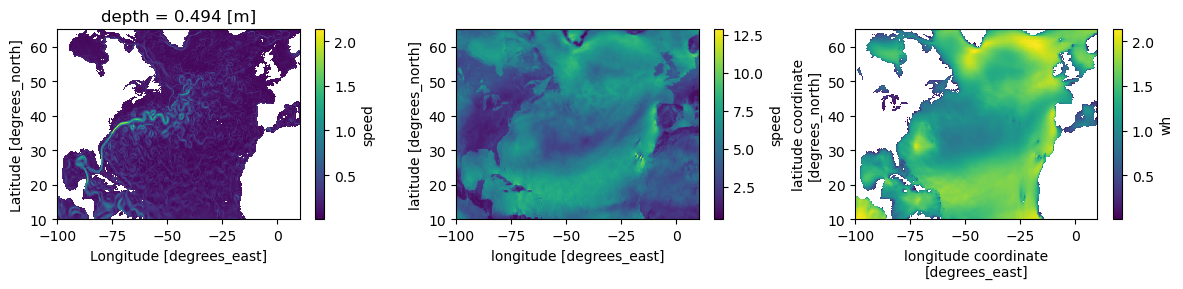

In [12]:
fig, ax = plt.subplots(1, 3, figsize=(12, 3))

currents.speed.mean("time").plot(ax=ax[0])
winds.speed.mean("time").plot(ax=ax[1])
waves.wh.mean("time").plot(ax=ax[2])

fig.tight_layout();

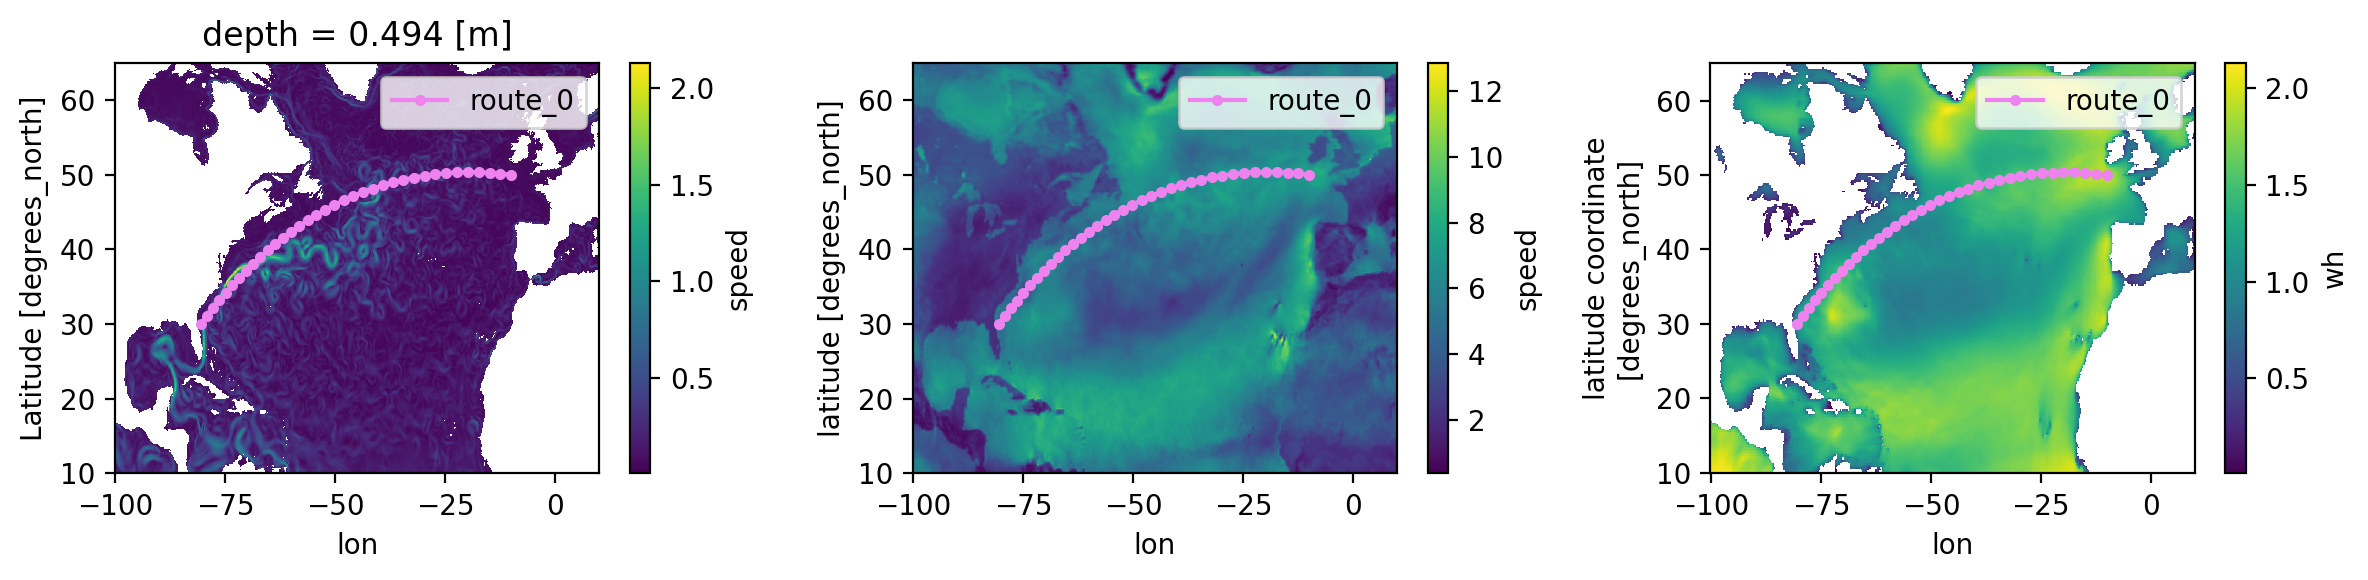

In [13]:
fig, ax = plt.subplots(1, 3, figsize=(12, 3))

fig.set_dpi(200)

currents.speed.mean("time").plot(ax=ax[0])
winds.speed.mean("time").plot(ax=ax[1])
waves.wh.mean("time").plot(ax=ax[2])

for _ax in ax.flatten():
    route_0.data_frame.plot.line(
        x="lon", y="lat", marker=".", ax=_ax, color="violet", label="route_0"
    )

fig.tight_layout();

## Concurrency

In [14]:
from dask import delayed

In [15]:
stochastic_search_delayed = delayed(stochastic_search)

In [16]:
population = [delayed(route_0) for _ in range(population_size)]

In [17]:
_currents = currents.compute()
_winds = winds.compute()
_waves = waves.compute()

In [18]:
from dask.distributed import Client

In [19]:
client = Client(n_workers=6, threads_per_worker=1, memory_limit=5e9)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 6
Total threads: 6,Total memory: 27.94 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:59040,Workers: 6
Dashboard: http://127.0.0.1:8787/status,Total threads: 6
Started: Just now,Total memory: 27.94 GiB
Comm: tcp://127.0.0.1:59056,Total threads: 1
Dashboard: http://127.0.0.1:59058/status,Memory: 4.66 GiB
Nanny: tcp://127.0.0.1:59043,


In [20]:
currents = client.scatter(currents, broadcast=True)
winds = client.scatter(winds, broadcast=True)
waves = client.scatter(waves, broadcast=True)

<frozen abc>:106: FutureWarning: xarray subclass HashableDataset should explicitly define __slots__
<frozen abc>:106: FutureWarning: xarray subclass HashableDataset should explicitly define __slots__
<frozen abc>:106: FutureWarning: xarray subclass HashableDataset should explicitly define __slots__
<frozen abc>:106: FutureWarning: xarray subclass HashableDataset should explicitly define __slots__
<frozen abc>:106: FutureWarning: xarray subclass HashableDataset should explicitly define __slots__
<frozen abc>:106: FutureWarning: xarray subclass HashableDataset should explicitly define __slots__


In [21]:
population_rl = [
    stochastic_search_delayed(
        route=r,
        number_of_iterations=stoch_number_of_iterations,
        acceptance_rate_target=stoch_acceptance_rate_target,
        mod_width=np.random.uniform(0.2, 1) * 0.75 * r.length_meters,
        max_move_meters=np.random.uniform(0.2, 1) * 0.75**0.5 * r.length_meters,
        current_data_set=currents,
        wave_data_set=waves,
        wind_data_set=winds,
    )
    for r in population
]

In [22]:
for n in range(3):
    population_rl = [
        stochastic_search_delayed(
            route=r[0],
            number_of_iterations=stoch_number_of_iterations,
            acceptance_rate_target=stoch_acceptance_rate_target,
            mod_width=np.random.uniform(0.2, 1) * 0.75 * r[0].length_meters,
            max_move_meters=np.random.uniform(0.2, 1) * 0.75**0.5 * r[0].length_meters,
            current_data_set=currents,
            wave_data_set=waves,
            wind_data_set=winds,
        )
        for r in population_rl
    ]

In [23]:
population_rl = [pc.compute() for pc in [pp.persist() for pp in population_rl]]

100%|██████████| 5/5 [00:01<00:00,  3.81it/s]


(array([  2.,   3.,   5.,   2.,  11.,   8.,  16.,  31.,  39., 123.]),
 array([6.46949157e+12, 6.49560120e+12, 6.52171084e+12, 6.54782048e+12,
        6.57393011e+12, 6.60003975e+12, 6.62614938e+12, 6.65225902e+12,
        6.67836866e+12, 6.70447829e+12, 6.73058793e+12]),
 <BarContainer object of 10 artists>)

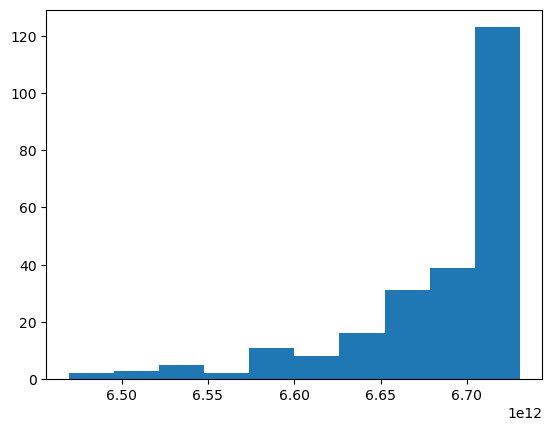

In [25]:
plt.hist([pd.concat([l.logs.data_frame for l in rl[1]], ignore_index=True).cost.min() for rl in population_rl])

In [ ]:
routes_costs = [
    route_mod_nonlocal_and_check_valid(
        route_cost=rc,
        current_data_set=currents,
        wind_data_set=winds,
        wave_data_set=waves,
        max_mod_size=route_0.length_meters / 2.0,
        max_mod_width=route_0.length_meters / 4.0,
    )
    for rc in routes_costs
]

In [ ]:
routes_costs = [
    route_mod_nonlocal_and_check_valid(
        route_cost=rc,
        current_data_set=currents,
        wind_data_set=winds,
        wave_data_set=waves,
        max_mod_size=route_0.length_meters / 2.0,
        max_mod_width=route_0.length_meters / 4.0,
    )
    for rc in routes_costs
]

In [ ]:
routes_crossed = [
    delayed_crossover_routes_minimal_cost(
        route_cost_0=routes_costs[np.random.randint(population_size)],
        route_cost_1=routes_costs[np.random.randint(population_size)],
        current_data_set=currents,
        wave_data_set=waves,
        wind_data_set=winds,
    )
    for n in range(population_size)
]

In [ ]:
%%time

routes_crossed = [rc.persist() for rc in routes_crossed]

cost_crossed = [
    route_cost_through(
        route=r,
        current_data_set=currents,
        wave_data_set=waves,
        wind_data_set=winds,
    )
    for r in routes_crossed
]
cost_crossed = [c.persist() for c in cost_crossed]
cost_crossed = [c.compute() for c in cost_crossed]

In [ ]:
cc = pd.Series(cost_crossed)
# cc = cc.where(cc < cost_0)
cc

In [ ]:
(cc.where(cc < cost_0) / cost_0).plot.hist(bins=20)

In [ ]:
(cc < cost_0).mean()

In [ ]:
cc.argmin()

In [ ]:
shapely.union(
    routes_crossed[cc.argmin()].compute().line_string,
    routes_crossed[cc.argmax()].compute().line_string,
)

In [ ]:
cc.min() / cost_0

In [ ]:
plt.plot(*routes_crossed[cc.argmin()].compute().line_string.xy, label="min")
plt.plot(*routes_crossed[cc.argmax()].compute().line_string.xy, label="max")
plt.plot(*route_0.line_string.xy, label="initial")
plt.legend()

In [ ]:
for r in routes_crossed:
    plt.plot(*r.compute().line_string.xy, "k-", alpha=0.1);